In [1]:
import os
import math
import matplotlib.pyplot as plt
import jax
import jax.numpy as np
import params
import model
import convert
import stimulus

In [2]:
def show_figure(states, times, figsize, dt, rows=5):
    cols = math.ceil((len(states) / rows))
    fig, ax = plt.subplots(cols, rows, figsize=figsize)
    idx = 0
    for col in range(cols):
        for row in range(rows):
            if idx >= len(states):
                return
            ax[col, row].imshow(states[idx], cmap="magma", vmin=0, vmax=1,)
            ax[col, row].set_title("Iter: " + str(times[idx + 1]) + " (%sms)" % convert.units_to_ms(times[idx + 1], dt))
            idx += 1

In [3]:
# simulation inputs (real values)
field_size = (11.25, 11.25)  # cm
d = 0.001  # (cm^2/ms)
cell_parameters = params.params6()
cell_parameters["tau_d"] = 0.3

In [4]:
# infinitesimals
dx = 0.015  # (cm/units) - Fenton 1998 recommends ~200, 300 micron/gridunit (~0.02, 0.03), smaller dx means finer grid
dt = 0.2  # (ms) - Fenton 1998 recommends few hundreds of ms (~0.01, 0.04)

(750, 750)
real tissue size: (11.25, 11.25)
Checkpointing at: [0, 1680, 1725, 1775, 1965, 2015, 2300, 2375, 2475, 2550, 2625, 2875, 3125, 4550, 5575, 5800, 6050, 6300, 6500, 6700, 6950, 7100, 7400, 7650, 8000, 8350]
{'tau_v_plus': 3.33, 'tau_v1_minus': 9, 'tau_v2_minus': 8, 'tau_w_plus': 250, 'tau_w_minus': 60, 'tau_d': 0.3, 'tau_0': 9, 'tau_r': 33.33, 'tau_si': 29, 'k': 15, 'V_csi': 0.5, 'V_c': 0.13, 'V_v': 0.04, 'Cm': 1}


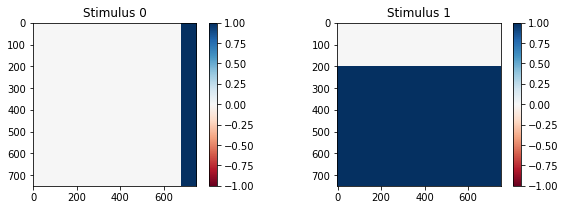

In [7]:
# to computational units
shape = convert.field_to_shape(field_size, dx)

stripe_size = int(shape[0] / 10)

protocol1 = stimulus.protocol(start=0, duration=2, period=0)
s1 = stimulus.rectangular(shape, jax.ops.index[:, -stripe_size:], 1., protocol1)

protocol2 = stimulus.protocol(start=convert.ms_to_units(200, dt), duration=2, period=0)
s2 = stimulus.rectangular(shape, jax.ops.index[convert.cm_to_units(3, dx):], 1., protocol2)

stimuli = [s1, s2]

checkpoints = [0, 336, 345, 355, 393, 403, 460, 475, 495, 510, 525, 575, 625, 910, 1115, 1160, 1210, 1260, 1300, 1340, 1390, 1420, 1480, 1530, 1600, 1670]
checkpoints = [convert.ms_to_units(ck, dt) for ck in checkpoints]

print(shape)
print("real tissue size:", field_size)
print("Checkpointing at:", checkpoints)
print(cell_parameters)
model.show_stimuli(*stimuli)

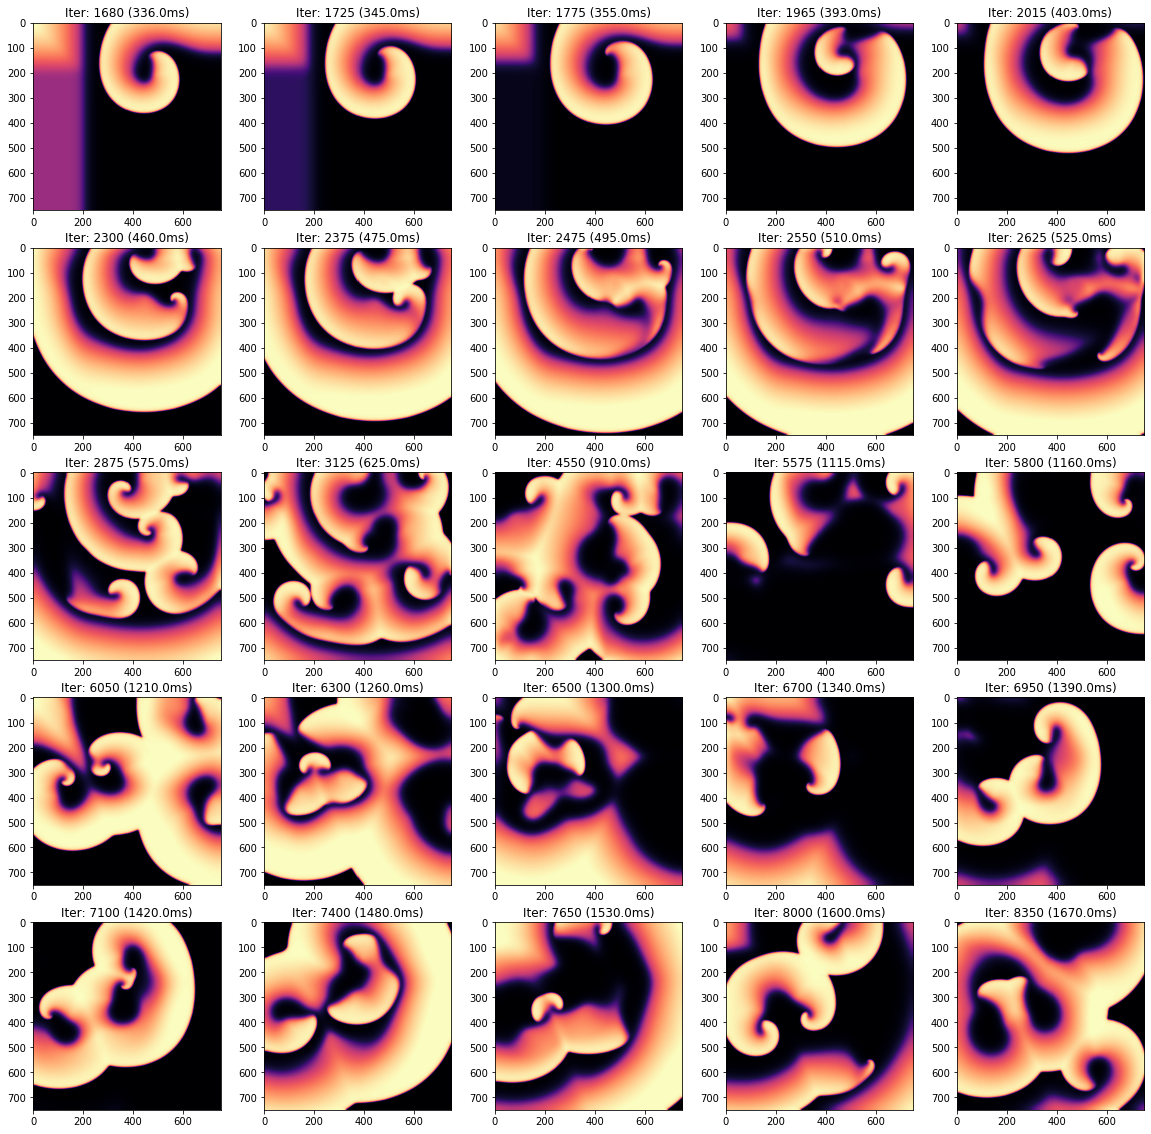

In [8]:
state = model.init(shape)
states = []
for i in range(len(checkpoints) - 1):
    state = model._forward(state, checkpoints[i], checkpoints[i + 1], cell_parameters, np.ones(shape) * d, stimuli, dt, dx)
    u = state[2]
    states.append(u)
#     model.show(state)
          
show_figure(states, checkpoints, (20, 20), dt)